<a href="https://colab.research.google.com/github/BillWorstell/derenzo_phantom/blob/master/iDerenzoRandomPytomograph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install os and sys, mount drive

In [1]:
#Install os and sys, mount drive
import os
import sys
from google.colab import drive
#drive.mount('/content/drive')

!pip install icecream
from icecream import ic

import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpp

#Get Multi-pinhole SPECT System Geometry

In [2]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/SPECTGeometry/'

Mounted at /content/drive


In [3]:
!ls -ltr /content/drive/MyDrive/SPECTGeometry/

total 1223
-rw------- 1 root root 461819 Dec 19 14:27 MDSL.excel80M10RFR.cut-plate.007.150roi.2.30pin.105ellipse.fix.xlsx
-rw------- 1 root root 790185 Dec 22 19:19 MDSL.excel80M10RFR.cut-plate.008.150roi.2.30pin.105ellipse.xlsx


Install openpyxl using pip

In [4]:
pip install openpyxl

https://openpyxl.readthedocs.io/en/stable/tutorial.html#loading-from-a-file

In [5]:
from openpyxl import load_workbook
wb = load_workbook(filename = '/content/drive/MyDrive/SPECTGeometry/MDSL.excel80M10RFR.cut-plate.008.150roi.2.30pin.105ellipse.xlsx',data_only=True)

loop through worksheets

In [6]:
for sheet in wb:
...     print(sheet.title)

Main
Coordinates
MDSL cloud import
Theta
Values
Design Table


Go to Coordinates Worksheet

In [7]:
wb.active = 1
print(wb.active.title)
ws = wb.active

Coordinates


Length of Collimator

In [8]:
ic(ws.cell(2,7).value)
lcoll=np.zeros(80)
for i in range(3,83):
  lcoll[i-3]=(ws.cell(i,7).value)

ic| ws.cell(2,7).value: 'length of collimator'


Choose vsdr = 5 * length of collimator, so by similar triangles

(2*5*lcoll)=source to virtual detector, or 10X

source to virtual detector is 10X size of actual detector

Size of detector at end of collimator is ~50mm

This implies dx * NX = 10 * 50mm ~ 500mm

dx ~ 500/256 ~2mm

    height=256,  # Height of the DRR (if width is not seperately provided, the generated image is square)
    delx=1.0,  # Pixel spacing (in mm)


In [9]:
vsdr=5.*lcoll

alpha: Azimuthal angle (radians)

In [10]:
ic(ws.cell(2,22).value)
alpha=np.zeros(80)
for i in range(3,83):
  alpha[i-3]=(ws.cell(i,22).value)

ic| ws.cell(2,22).value: 'pinhole azimuth (radians)'


beta = altitude (radians)

In [11]:
ic(ws.cell(2,23).value)
beta=np.zeros(80)
for i in range(3,83):
  beta[i-3]=(ws.cell(i,23).value)

ic| ws.cell(2,23).value: 'pinhole elevation (radians)'


#Install required packages

##Import pytorch3d

In [12]:
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("2.1.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'



## Install pytomography

See https://pytomography.readthedocs.io/en/latest/usage.html

and in particular https://pytomography.readthedocs.io/en/latest/notebooks/t_fbp.html

Modified to run from Google Colab: https://colab.research.google.com/

Data stored on Google Drive in path = '/content/drive/MyDrive/pytomography_tutorial_data/simind_tutorial/'

May require restart after first run

Tested with V100 GPU on Colab

Get pytomography verssion from github

In [13]:
!pip install 'git+https://github.com/BillWorstell/pytomography.git'

  Cloning https://github.com/BillWorstell/pytomography.git to /tmp/pip-req-build-ujrc8wr4
  Running command git clone --filter=blob:none --quiet https://github.com/BillWorstell/pytomography.git /tmp/pip-req-build-ujrc8wr4
  Resolved https://github.com/BillWorstell/pytomography.git to commit 19dee22bf1f93e6e7d6fa0ab2a66011dcd7171ad
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done



https://vivekg.dev/DiffDRR/

install DiffDRR from PyPI:

In [14]:
!pip install diffdrr

Install icecream for debug printing

https://github.com/gruns/icecream

In [15]:
!pip install icecream
from icecream import ic

##Get DiffDRR version from github

Use the version of DiffDRR posted on github

Git clone from github publib open source code to colab working directory

See https://stackoverflow.com/questions/50850216/google-colab-install-from-github-glrm

In [16]:
!pip install 'git+https://github.com/BillWorstell/DiffDRR.git'

  Cloning https://github.com/BillWorstell/DiffDRR.git to /tmp/pip-req-build-nftev25i
  Running command git clone --filter=blob:none --quiet https://github.com/BillWorstell/DiffDRR.git /tmp/pip-req-build-nftev25i
  Resolved https://github.com/BillWorstell/DiffDRR.git to commit 9f19b9232b78843302f05be08f4751a628761669
  Preparing metadata (setup.py) ... done


Import diffdrr ct example

In [17]:
from diffdrr.data import load_example_ct
from diffdrr.drr import DRR
from diffdrr.visualization import plot_drr

Check /content/

In [18]:
!ls -ltr /content/
!ls -ltr /content/derenzo_phantom

ls: cannot access '/content/gdrive': Transport endpoint is not connected
total 20
d????????? ? ?    ?       ?            ? gdrive
drwxr-xr-x 1 root root 4096 Jan 29 14:26 sample_data
-rw-r--r-- 1 root root  200 Jan 30 18:35 RunTranslate.npy
-rw-r--r-- 1 root root  200 Jan 30 18:35 RunRotate.npy
drwxr-xr-x 4 root root 4096 Jan 30 18:44 derenzo_phantom
drwx------ 5 root root 4096 Jan 30 18:52 drive
total 15436
-rw-r--r-- 1 root root 1313334 Jan 30 18:44 'DeRenzo Pytomography.pdf'
-rw-r--r-- 1 root root 1545339 Jan 30 18:44 'DeRenzo iCheckRotations ipynb.pdf'
-rw-r--r-- 1 root root 1803321 Jan 30 18:44  DerenzoPytomography.ipynb
-rw-r--r-- 1 root root     303 Jan 30 18:44  README.md
-rw-r--r-- 1 root root    4270 Jan 30 18:44  derenzo_log.py
-rw-r--r-- 1 root root 1296108 Jan 30 18:44  iCheckDRRs.ipynb
-rw-r--r-- 1 root root 2680111 Jan 30 18:44  iCheckRotations.ipynb
-rw-r--r-- 1 root root  718092 Jan 30 18:44  iCheckSinograms.ipynb
-rw-r--r-- 1 root root 1256341 Jan 30 18:44  iDerenzoPy

##Uncomment below to get derenzo_phantom version from github

In [19]:
!rm /content/derenzo_phantom -rf
!git clone https://github.com/Billworstell/derenzo_phantom.git

Cloning into 'derenzo_phantom'...
remote: Enumerating objects: 172, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 172 (delta 46), reused 89 (delta 42), pack-reused 70
Receiving objects: 100% (172/172), 15.20 MiB | 16.67 MiB/s, done.
Resolving deltas: 100% (79/79), done.


look around

In [20]:
!pwd
!ls -ltr

!ls -ltr /content
!ls -ltr /content/derenzo_phantom/
!ls -ltr /content/derenzo_phantom/derenzo_log.py

/content
ls: cannot access 'gdrive': Transport endpoint is not connected
total 20
d????????? ? ?    ?       ?            ? gdrive
drwxr-xr-x 1 root root 4096 Jan 29 14:26 sample_data
-rw-r--r-- 1 root root  200 Jan 30 18:35 RunTranslate.npy
-rw-r--r-- 1 root root  200 Jan 30 18:35 RunRotate.npy
drwx------ 5 root root 4096 Jan 30 18:52 drive
drwxr-xr-x 3 root root 4096 Jan 30 18:53 derenzo_phantom
ls: cannot access '/content/gdrive': Transport endpoint is not connected
total 20
d????????? ? ?    ?       ?            ? gdrive
drwxr-xr-x 1 root root 4096 Jan 29 14:26 sample_data
-rw-r--r-- 1 root root  200 Jan 30 18:35 RunTranslate.npy
-rw-r--r-- 1 root root  200 Jan 30 18:35 RunRotate.npy
drwx------ 5 root root 4096 Jan 30 18:52 drive
drwxr-xr-x 3 root root 4096 Jan 30 18:53 derenzo_phantom
total 15432
-rw-r--r-- 1 root root 1313334 Jan 30 18:53 'DeRenzo Pytomography.pdf'
-rw-r--r-- 1 root root 1545339 Jan 30 18:53 'DeRenzo iCheckRotations ipynb.pdf'
-rw-r--r-- 1 root root 1803321 Jan 30

##Install derenzo_phantom

In [21]:
sys.path.append('/content/derenzo_phantom/')
from phantom import DerenzoPhantom

In [22]:
# import math for rotation Matrix multiplication
import math as m

def Rx(theta):
  return np.matrix([[ 1, 0           , 0           ],
                   [ 0, m.cos(theta),-m.sin(theta)],
                   [ 0, m.sin(theta), m.cos(theta)]])

def Ry(theta):
  return np.matrix([[ m.cos(theta), 0, m.sin(theta)],
                   [ 0           , 1, 0           ],
                   [-m.sin(theta), 0, m.cos(theta)]])

def Rz(theta):
  return np.matrix([[ m.cos(theta), -m.sin(theta), 0 ],
                   [ m.sin(theta), m.cos(theta) , 0 ],
                   [ 0           , 0            , 1 ]])



##Filtered Back Projection
We’ll use the classes of PyTomography to implement filtered back projection in SPECT.

In [23]:
from pytomography.algorithms import FilteredBackProjection
from pytomography.projectors.SPECT import SPECTSystemMatrix
from pytomography.metadata import SPECTObjectMeta, SPECTProjMeta
from pytomography.transforms.SPECT import SPECTAttenuationTransform, SPECTPSFTransform
from pytomography.utils import HammingFilter
import numpy as np
import matplotlib.pyplot as plt
import torch
from pytomography.io.SPECT import dicom

#Specify 2D Phantom Geometry

---



Use reference phantom, but translate and rotate randomly

ic| SectorMask.sum(): 24658.0
ic| self.mask.sum(): 24658.0
ic| SectorMask.sum(): 13852.0
ic| self.mask.sum(): 38510.0
ic| SectorMask.sum(): 19282.0
ic| self.mask.sum(): 57792.0
ic| SectorMask.sum(): 20540.0
ic| self.mask.sum(): 78332.0
ic| SectorMask.sum(): 17322.0
ic| self.mask.sum(): 95654.0
ic| SectorMask.sum(): 18491.0
ic| self.mask.sum(): 114145.0


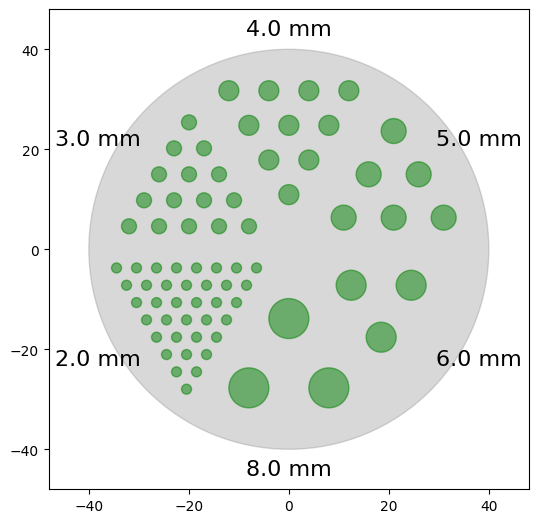

In [24]:
radius = 40.0
well_seps = (8.0, 6.0, 5.0, 4.0, 3.0, 2.0)
test_phantom = DerenzoPhantom(radius, well_seps, )
#test_phantom.show()

Generate Mask for reference phantom

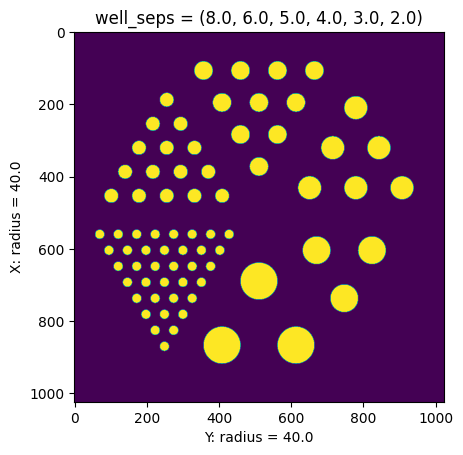

In [25]:
myMask=test_phantom.mask.reshape(1024,1024)
plt.imshow(np.flipud(myMask))

plt.title('well_seps = (8.0, 6.0, 5.0, 4.0, 3.0, 2.0)')
plt.xlabel(f'Y: radius = {radius}')
plt.ylabel(f'X: radius = {radius}')
plt.show()

ic| myMask.shape: (1024, 1024)
ic| myMask.sum(): 114145.0


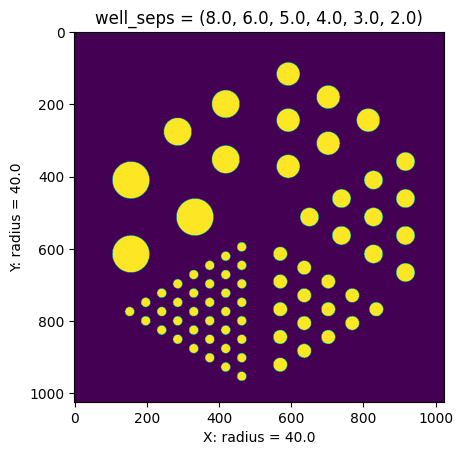

In [26]:
myMask=test_phantom.mask.reshape(1024,1024)
ic(myMask.shape)
ic(myMask.sum())
#plt.imshow(myMask)
plt.imshow(np.flipud(myMask.T))

plt.title('well_seps = (8.0, 6.0, 5.0, 4.0, 3.0, 2.0)')
plt.xlabel(f'X: radius = {radius}')
plt.ylabel(f'Y: radius = {radius}')
plt.show()

make meshgrid from volume and spacing

In [27]:
#volume, spacing = load_example_ct()
volume=np.zeros([256,256,256])
spacing=[1.0, 1.0, 1.0]
bx, by, bz = torch.tensor(volume.shape) * torch.tensor(spacing) / 2
ic(bx, by, bz)
ic(volume.shape)
ic(spacing)

ic| bx: tensor(128.), by: tensor(128.), bz: tensor(128.)
ic| volume.shape: (256, 256, 256)
ic| spacing: [1.0, 1.0, 1.0]


[1.0, 1.0, 1.0]

Get lab frame coordinates for voxels in volume

In [28]:
xlinspace=np.linspace(-128*spacing[0], 128*spacing[0], 256)
ylinspace=np.linspace(-128*spacing[1], 128*spacing[1], 256)
zlinspace=np.linspace(-128*spacing[2], 128*spacing[2], 256)
xgrid,ygrid,zgrid = np.meshgrid(xlinspace, ylinspace,zlinspace)
xgrid=xgrid.flatten()
ygrid=ygrid.flatten()
zgrid=zgrid.flatten()

Define rotateImage for psi rotation of phantom, using scipy ndimage

In [29]:
from scipy import ndimage

def rotateImage(img, angle, pivot):
    padX = [img.shape[1] - pivot[0], pivot[0]]
    padY = [img.shape[0] - pivot[1], pivot[1]]
    imgP = np.pad(img, [padY, padX], 'constant')
    imgR = ndimage.rotate(imgP, angle, reshape=False)
    return imgR[padY[0] : -padY[1], padX[0] : -padX[1]]


#Iterate over instances of phantom random translation and rotation

Use os.path.exists() to determine if data was previously produced and is available with its parameters recorded.

See https://docs.python.org/3/library/os.path.html

Mount google drive as gdrive

In [30]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [31]:
#overwriteCurrentFiles=True
overwriteCurrentFiles=False
NRuns=100

if os.path.exists('RunTranslate.npy'):
  OldRunTranslatePhantom=np.load('RunTranslate.npy')
  OldNRuns=OldRunTranslatePhantom.shape[0]
  RunTranslatePhantom=np.zeros([NRuns,3])
  RunTranslatePhantom[0:OldNRuns,:]=OldRunTranslatePhantom
else:
  RunTranslatePhantom=np.zeros([NRuns,3])

if os.path.exists('RunRotate.npy'):
  RunRotatePhantom=np.load('RunRotate.npy')
  OldRunRotatePhantom=np.load('RunRotate.npy')
  OldNRuns=OldRunRotatePhantom.shape[0]
  RunRotatePhantom=np.zeros([NRuns,3])
  RunRotatePhantom[0:OldNRuns,:]=OldRunRotatePhantom
else:
  RunRotatePhantom=np.zeros([NRuns,3])
#
###############
#
# Loop over runs and generate them if either
#  overwriteCurrentFiles: True -> data generated and overwritten if existing
#  overwriteCurrentFiles: False-> data generated if not existing
#
###############
#
for iRun in range(0,NRuns):
  # Check whether data for this event currently exists
  truthFound=os.path.exists(f'/content/gdrive/MyDrive/data/derenzo_phantom/truth_{iRun}.pt')
  if (overwriteCurrentFiles):
    Needed=True
    print(f'Overwrite iRun={iRun}, Needed={Needed}')
  else:
    Needed=not truthFound
    print(f'NoOverwrite iRun={iRun}, Needed={Needed}')

  if (Needed):
    PhantomHalfZ=radius
    spacingPhantom=[(2.*radius)/1024.,2.*radius/1024.,2.*PhantomHalfZ]
    TranslateX=radius*((2.*np.random.rand())-1.)
    TranslateY=radius*((2.*np.random.rand())-1.)
    TranslatePhantom=[TranslateX,TranslateY,0.]
    RunTranslatePhantom[iRun,:]=TranslatePhantom
    np.save('RunTranslate.npy',RunTranslatePhantom)

    # specify Euler angles for establishing Phantom orientation in lab frame
    psi=(2.*np.pi)*np.random.rand()
    phi=(2.*np.pi)*np.random.rand()
    theta=  np.pi *np.random.rand()
    psiDeg=psi*(180./np.pi)
    thetaDeg=theta*(180./np.pi)
    phiDeg=phi*(180./np.pi)
    RotatePhantom=[phi,theta,psi]
    RunRotatePhantom[iRun,:]=RotatePhantom
    np.save('RunRotate.npy',RunRotatePhantom)

    # Transform from lab frame 'grid' to phantom reference frame through a series of transformations
    #
    # Invert translation from Lab System origin to Phantom System origin
    xp1 = xgrid-TranslatePhantom[0]
    yp1 = ygrid-TranslatePhantom[1]
    zp1 = zgrid-TranslatePhantom[2]
    v1 = np.array([xp1,yp1,zp1])

    R_Invert=  Ry(-theta) * Rz(-phi)
    v2 = R_Invert * v1
    xp2=v2[0,:]
    yp2=v2[1,:]
    zp2=v2[2,:]
    xp3=np.squeeze(np.asarray(xp2))
    yp3=np.squeeze(np.asarray(yp2))
    zp3=np.squeeze(np.asarray(zp2))

    ixPh=np.floor(((xp3+radius)/spacingPhantom[0])).astype(int)
    iyPh=np.floor(((yp3+radius)/spacingPhantom[1])).astype(int)

    # Input test phantom reference mask and rotate by psi
    phantomMask=test_phantom.mask.reshape(1024,1024)
    pivot=[511,511]
    phantomMaskR=rotateImage(phantomMask, psiDeg, pivot)

    volumeShape=[256, 256, 256]
    phantomShape=[1024,1024]
    volume=np.zeros(volumeShape).flatten()

    validX=(ixPh>=0) & (ixPh<phantomShape[0])
    validY=(iyPh>=0) & (iyPh<phantomShape[1])
    validZ=(zp3>=-PhantomHalfZ) & (zp3<=PhantomHalfZ)
    valid=(validX & validY & validZ).flatten()
    ixPh2=ixPh[valid]
    iyPh2=iyPh[valid]
    volume[valid]=phantomMaskR[ixPh2,iyPh2]
    volume=volume.reshape(volumeShape)

    PVCvolume=np.zeros(volume.shape,dtype=np.float32)
    PVCvolume[1:255, 1:255, :] += volume[0:254, 0:254, :] / 9.
    PVCvolume[1:255, 1:255, :] += volume[0:254, 1:255, :] / 9.
    PVCvolume[1:255, 1:255, :] += volume[0:254, 2:256, :] / 9.
    PVCvolume[1:255, 1:255, :] += volume[1:255, 0:254, :] / 9.
    PVCvolume[1:255, 1:255, :] += volume[1:255, 1:255, :] / 9.
    PVCvolume[1:255, 1:255, :] += volume[1:255, 2:256, :] / 9.
    PVCvolume[1:255, 1:255, :] += volume[2:256, 0:254, :] / 9.
    PVCvolume[1:255, 1:255, :] += volume[2:256, 1:255, :] / 9.
    PVCvolume[1:255, 1:255, :] += volume[2:256, 2:256, :] / 9.
    volume = PVCvolume
    #
    ############################
    # Generate DRRs
    ############################
    #
    #| cuda
    # Read in the volume and get the isocenter
    bx, by, bz = torch.tensor(volume.shape) * torch.tensor(spacing) / 2
    # Initialize the DRR module for generating synthetic X-rays
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    #Collect Projections over all modules
    Projections=torch.zeros([96,256,256])

    ic(iRun)
    for iRow in range(0,4):
      ic(iRow)
      for iCol in range(0,20):
        #ic(iCol)
        imod=iRow*20+iCol

        drr = DRR(
            volume,  # The CT volume as a numpy array
            spacing,  # Voxel dimensions of the CT
            sdr=float(vsdr[imod]),  # Source-to-detector radius (half of the source-to-detector distance)
            height=256,  # Height of the DRR (if width is not seperately provided, the generated image is square)
            delx=2.0,  # Pixel spacing (in mm)
              ).to(device)

        # Set the camera pose with rotations (yaw, pitch, roll) and translations (x, y, z)
      rotations = torch.tensor([[float(alpha[imod]), float(beta[imod]), torch.pi / 2]], device=device)
      translations = torch.tensor([[bx, by, bz]], device=device)
      img = drr(rotations, translations, parameterization="euler_angles", convention="ZYX")
      Projections[imod,:,:]=img[0,0,:,:]

    object_truth = torch.from_numpy(volume)
    object_truth = object_truth.unsqueeze(dim=0) # add batch dimension
    ic(object_truth.shape)
    torch.save(object_truth,f'/content/gdrive/MyDrive/data/derenzo_phantom/truth_{iRun}.pt')
    torch.save(Projections,f'/content/gdrive/MyDrive/data/derenzo_phantom/Projections_{iRun}.pt')
    #
    ##########################################
    #   96 Projections Somewhat Sparse Angle Case
    ##########################################
    #
    angleStep= 360./96.
    angles = np.arange(0,360.,angleStep)
    radii = 50 * np.ones(len(angles))
    object_meta = SPECTObjectMeta(dr=(spacing[0],spacing[1],spacing[2]), shape=object_truth[0].shape)
    proj_meta = SPECTProjMeta(projection_shape=object_truth[0,0].shape, angles=angles, radii=radii)
    system_matrix_radon = SPECTSystemMatrix(
        obj2obj_transforms=[],
        proj2proj_transforms=[],
        object_meta=object_meta,
        proj_meta=proj_meta)
    proj_radon = system_matrix_radon.forward(object_truth)
    ic(proj_radon.shape)
    torch.save(proj_radon,f'/content/gdrive/MyDrive/data/derenzo_phantom/ProjRadon96_{iRun}.pt')
    #
    ##########################################
    #   256 Projections 'Full' Angle Case
    ##########################################
    #
    angleStep= 360./256.
    angles = np.arange(0,360.,angleStep)
    radii = 50 * np.ones(len(angles))
    object_meta = SPECTObjectMeta(dr=(spacing[0],spacing[1],spacing[2]), shape=object_truth[0].shape)
    proj_meta = SPECTProjMeta(projection_shape=object_truth[0,0].shape, angles=angles, radii=radii)
    system_matrix_radon = SPECTSystemMatrix(
        obj2obj_transforms=[],
        proj2proj_transforms=[],
        object_meta=object_meta,
        proj_meta=proj_meta)
    proj_radon = system_matrix_radon.forward(object_truth)
    ic(proj_radon.shape)
    torch.save(proj_radon,f'/content/gdrive/MyDrive/data/derenzo_phantom/ProjRadon256_{iRun}.pt')

!ls -ltr /content/gdrive/MyDrive/data/derenzo_phantom



NoOverwrite iRun=0, Needed=False
NoOverwrite iRun=1, Needed=False
NoOverwrite iRun=2, Needed=False
NoOverwrite iRun=3, Needed=True


ic| iRun: 3
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=4, Needed=True


ic| iRun: 4
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=5, Needed=True


ic| iRun: 5
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=6, Needed=True


ic| iRun: 6
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=7, Needed=True


ic| iRun: 7
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=8, Needed=True


ic| iRun: 8
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=9, Needed=True


ic| iRun: 9
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=10, Needed=True


ic| iRun: 10
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=11, Needed=True


ic| iRun: 11
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=12, Needed=True


ic| iRun: 12
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=13, Needed=True


ic| iRun: 13
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=14, Needed=True


ic| iRun: 14
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=15, Needed=True


ic| iRun: 15
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=16, Needed=True


ic| iRun: 16
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=17, Needed=True


ic| iRun: 17
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=18, Needed=True


ic| iRun: 18
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=19, Needed=True


ic| iRun: 19
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=20, Needed=True


ic| iRun: 20
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=21, Needed=True


ic| iRun: 21
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=22, Needed=True


ic| iRun: 22
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=23, Needed=True


ic| iRun: 23
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=24, Needed=True


ic| iRun: 24
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=25, Needed=True


ic| iRun: 25
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=26, Needed=True


ic| iRun: 26
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=27, Needed=True


ic| iRun: 27
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=28, Needed=True


ic| iRun: 28
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=29, Needed=True


ic| iRun: 29
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=30, Needed=True


ic| iRun: 30
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=31, Needed=True


ic| iRun: 31
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=32, Needed=True


ic| iRun: 32
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=33, Needed=True


ic| iRun: 33
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=34, Needed=True


ic| iRun: 34
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=35, Needed=True


ic| iRun: 35
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=36, Needed=True


ic| iRun: 36
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=37, Needed=True


ic| iRun: 37
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=38, Needed=True


ic| iRun: 38
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=39, Needed=True


ic| iRun: 39
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=40, Needed=True


ic| iRun: 40
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=41, Needed=True


ic| iRun: 41
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=42, Needed=True


ic| iRun: 42
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=43, Needed=True


ic| iRun: 43
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=44, Needed=True


ic| iRun: 44
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=45, Needed=True


ic| iRun: 45
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=46, Needed=True


ic| iRun: 46
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=47, Needed=True


ic| iRun: 47
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=48, Needed=True


ic| iRun: 48
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=49, Needed=True


ic| iRun: 49
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=50, Needed=True


ic| iRun: 50
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=51, Needed=True


ic| iRun: 51
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=52, Needed=True


ic| iRun: 52
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=53, Needed=True


ic| iRun: 53
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=54, Needed=True


ic| iRun: 54
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=55, Needed=True


ic| iRun: 55
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=56, Needed=True


ic| iRun: 56
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=57, Needed=True


ic| iRun: 57
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=58, Needed=True


ic| iRun: 58
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=59, Needed=True


ic| iRun: 59
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=60, Needed=True


ic| iRun: 60
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=61, Needed=True


ic| iRun: 61
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=62, Needed=True


ic| iRun: 62
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=63, Needed=True


ic| iRun: 63
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=64, Needed=True


ic| iRun: 64
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=65, Needed=True


ic| iRun: 65
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=66, Needed=True


ic| iRun: 66
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=67, Needed=True


ic| iRun: 67
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=68, Needed=True


ic| iRun: 68
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=69, Needed=True


ic| iRun: 69
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=70, Needed=True


ic| iRun: 70
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=71, Needed=True


ic| iRun: 71
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=72, Needed=True


ic| iRun: 72
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=73, Needed=True


ic| iRun: 73
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=74, Needed=True


ic| iRun: 74
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=75, Needed=True


ic| iRun: 75
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=76, Needed=True


ic| iRun: 76
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=77, Needed=True


ic| iRun: 77
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=78, Needed=True


ic| iRun: 78
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=79, Needed=True


ic| iRun: 79
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=80, Needed=True


ic| iRun: 80
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=81, Needed=True


ic| iRun: 81
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=82, Needed=True


ic| iRun: 82
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=83, Needed=True


ic| iRun: 83
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=84, Needed=True


ic| iRun: 84
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=85, Needed=True


ic| iRun: 85
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=86, Needed=True


ic| iRun: 86
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=87, Needed=True


ic| iRun: 87
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=88, Needed=True


ic| iRun: 88
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=89, Needed=True


ic| iRun: 89
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=90, Needed=True


ic| iRun: 90
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=91, Needed=True


ic| iRun: 91
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=92, Needed=True


ic| iRun: 92
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=93, Needed=True


ic| iRun: 93
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=94, Needed=True


ic| iRun: 94
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=95, Needed=True


ic| iRun: 95
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=96, Needed=True


ic| iRun: 96
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=97, Needed=True


ic| iRun: 97
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=98, Needed=True


ic| iRun: 98
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


NoOverwrite iRun=99, Needed=True


ic| iRun: 99
ic| iRow: 0
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 1
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 2
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| iRow: 3
ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| proj_radon.shape: torch.Size([1, 96, 256, 256])
ic| proj_radon.shape: torch.Size([1, 256, 256, 256])


total 21890138
-rw------- 1 root root 67110054 Jan 30 17:12 truth_002.pt
-rw------- 1 root root 35783866 Jan 30 18:19 ProjRadon96_1.pt
-rw------- 1 root root 95421631 Jan 30 18:19 ProjRadon256_1.pt
-rw------- 1 root root 35783866 Jan 30 18:24 ProjRadon96_0.pt
-rw------- 1 root root 95421631 Jan 30 18:24 ProjRadon256_0.pt
-rw------- 1 root root 67110044 Jan 30 18:25 truth_1.pt
-rw------- 1 root root 25167034 Jan 30 18:25 Projections_1.pt
-rw------- 1 root root 67110044 Jan 30 18:27 truth_0.pt
-rw------- 1 root root 25167034 Jan 30 18:27 Projections_0.pt
-rw------- 1 root root 67110044 Jan 30 18:36 truth_2.pt
-rw------- 1 root root 25167034 Jan 30 18:36 Projections_2.pt
-rw------- 1 root root 35783866 Jan 30 18:36 ProjRadon96_2.pt
-rw------- 1 root root 95421631 Jan 30 18:36 ProjRadon256_2.pt
-rw------- 1 root root 67110044 Jan 30 18:55 truth_3.pt
-rw------- 1 root root 25167034 Jan 30 18:55 Projections_3.pt
-rw------- 1 root root 35783866 Jan 30 18:55 ProjRadon96_3.pt
-rw------- 1 root 

# Generate Displays for last random event

##Display Phantom projections within volume

ic| volume.shape: (256, 256, 256)
ic| SumX.shape: (256, 256)
ic| SumY.shape: (256, 256)
ic| SumZ.shape: (256, 256)


Text(0.5, 1.0, 'T= [-17.5, 18.7, 0.0] R= [psi=297.4, theta=43.8, phi=298.4] ')

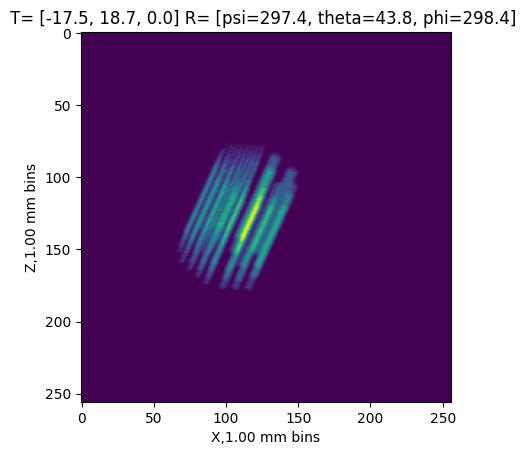

In [32]:
ic(volume.shape)
SumX=volume.sum(0)
SumY=volume.sum(1)
SumZ=volume.sum(2)
ic(SumX.shape)
ic(SumY.shape)
ic(SumZ.shape)

ThisAspect=spacing[2]/spacing[0]
plt.imshow(np.flipud(SumX.T),aspect=ThisAspect)
plt.xlabel(f'X,{spacing[0]:0.2f} mm bins')
plt.ylabel(f'Z,{spacing[2]:0.2f} mm bins')
TranslateString=f'T= [{TranslatePhantom[0]:.1f}, ' + f'{TranslatePhantom[1]:.1f}, ' + f'{TranslatePhantom[2]:.1f}] '
RotateString=f'R= [psi={psiDeg:.1f}, ' + f'theta={thetaDeg:.1f}, ' + f'phi={phiDeg:.1f}] '
plt.title(TranslateString + RotateString)

Text(0.5, 1.0, 'T= [-17.5, 18.7, 0.0] R= [psi=297.4, theta=43.8, phi=298.4] ')

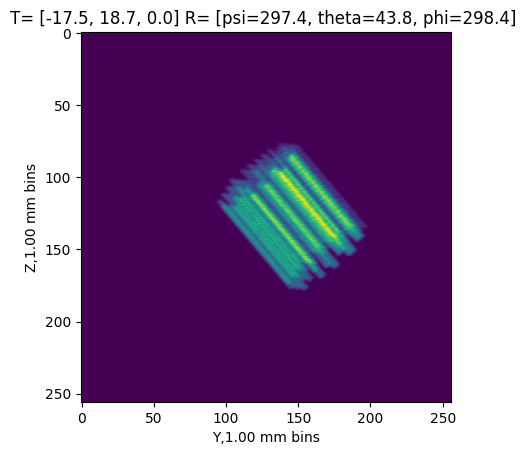

In [33]:
ThisAspect=spacing[2]/spacing[0]
plt.imshow(np.flipud(SumY.T),aspect=ThisAspect)
plt.xlabel(f'Y,{spacing[0]:0.2f} mm bins')
plt.ylabel(f'Z,{spacing[2]:0.2f} mm bins')
TranslateString=f'T= [{TranslatePhantom[0]:.1f}, ' + f'{TranslatePhantom[1]:.1f}, ' + f'{TranslatePhantom[2]:.1f}] '
RotateString=f'R= [psi={psiDeg:.1f}, ' + f'theta={thetaDeg:.1f}, ' + f'phi={phiDeg:.1f}] '
plt.title(TranslateString + RotateString)

Text(0.5, 1.0, 'T= [-17.5, 18.7, 0.0] R= [psi=297.4, theta=43.8, phi=298.4] ')

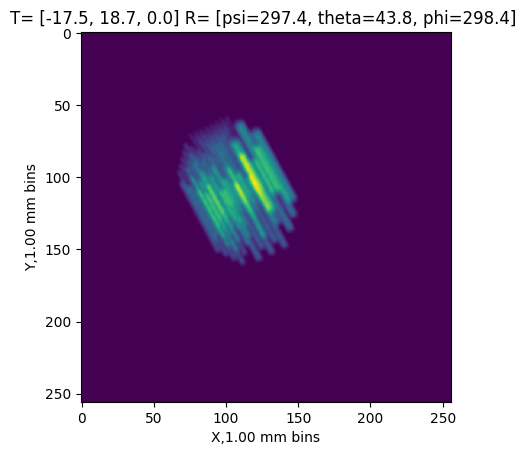

In [34]:
plt.imshow(np.flipud(SumZ))
plt.xlabel(f'X,{spacing[0]:0.2f} mm bins')
plt.ylabel(f'Y,{spacing[1]:0.2f} mm bins')
TranslateString=f'T= [{TranslatePhantom[0]:.1f}, ' + f'{TranslatePhantom[1]:.1f}, ' + f'{TranslatePhantom[2]:.1f}] '
RotateString=f'R= [psi={psiDeg:.1f}, ' + f'theta={thetaDeg:.1f}, ' + f'phi={phiDeg:.1f}] '
plt.title(TranslateString + RotateString)

#Make DRRs for PVCvolume

Get characteristics of volume

In [35]:
ic(volume.dtype)
ic(volume.shape)
ic(volume.size)

ic| volume.dtype: dtype('float32')
ic| volume.shape: (256, 256, 256)
ic| volume.size: 16777216


16777216

DRR Generation

DiffDRR is implemented as a custom PyTorch module.

All raytracing operations have been formulated in a vectorized function, enabling use of PyTorch's GPU support and autograd. This also means that DRR generation is available as a layer in deep learning frameworks.

In [36]:
#| cuda
# Read in the volume and get the isocenter
#volume, spacing = load_example_ct()
bx0, by0, bz0 = torch.tensor(volume.shape) * torch.tensor(spacing) / 2
ic(bx0.dtype)
bx, by, bz = torch.tensor(volume.shape) * torch.tensor(spacing) / 2
ic(bx.dtype)
# Initialize the DRR module for generating synthetic X-rays
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Collect Pseudosinogram for central Z slice
Sinogram0=np.zeros([256,24])
Projections=torch.zeros([24,256,256])

for imod in range(0,20):
  drr = DRR(
    volume,  # The CT volume as a numpy array
    spacing,  # Voxel dimensions of the CT
    sdr=float(vsdr[imod]),  # Source-to-detector radius (half of the source-to-detector distance)
    height=256,  # Height of the DRR (if width is not seperately provided, the generated image is square)
    delx=2.0,  # Pixel spacing (in mm)
  ).to(device)

  # Set the camera pose with rotations (yaw, pitch, roll) and translations (x, y, z)
  rotations = torch.tensor([[float(alpha[imod]), float(beta[imod]), torch.pi / 2]], device=device)
  translations = torch.tensor([[bx, by, bz]], device=device)
  img = drr(rotations, translations, parameterization="euler_angles", convention="ZYX")

  Projections[imod,:,:]=img[0,0,:,:]
  Sinogram0[:,imod]=img[0,0,125,:].cpu()

ic| bx0.dtype: torch.float32
ic| bx.dtype: torch.float32


Extrapolate to (approximate) missing angles using (approximate) complementary angles

ic| Projections.shape: torch.Size([24, 256, 256])
ic| Sinogram0.shape: (256, 24)
ic| CompProj.shape: torch.Size([256, 256])
ic| CompProj.shape: (256, 256)
ic| CompProj.shape: torch.Size([256, 256])
ic| CompProj.shape: (256, 256)
ic| CompProj.shape: torch.Size([256, 256])
ic| CompProj.shape: (256, 256)
ic| CompProj.shape: torch.Size([256, 256])
ic| CompProj.shape: (256, 256)


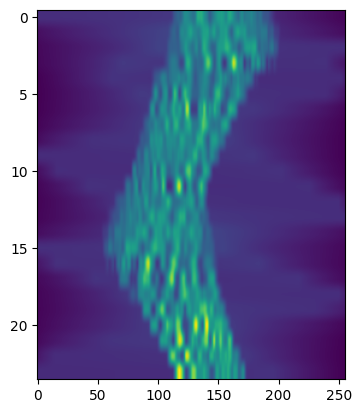

In [37]:
ic(Projections.shape)
ic(Sinogram0.shape)
for imod in range(20,24):
  CompProj=torch.flip(Projections[imod-13,:,:],[1])
  Projections[imod,:,:]=CompProj
  ic(CompProj.shape)
  CompProj=CompProj.detach().cpu().numpy()
  ic(CompProj.shape)
  #Sinogram0[:,imod]=img[0,0,125,:].cpu()
  Sinogram0[:,imod]=CompProj[125,:]

ThisAspect=256./20.
plt.imshow(np.flipud(Sinogram0.T),aspect=ThisAspect)

Save Projections for single instance to

See https://pytorch.org/docs/stable/generated/torch.save.html


From https://stackoverflow.com/questions/10016352/convert-numpy-array-to-tuple

Compact FOV Display for all 80 modules

ic| img.shape: torch.Size([1, 1, 256, 256])
/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:836: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
ic| BigImage.shape: torch.Size([4, 256, 24, 256])
ic| BigImage.shape: torch.Size([4, 256, 24, 256])
ic| BigImage.shape: torch.Size([1, 1, 1024, 6144])


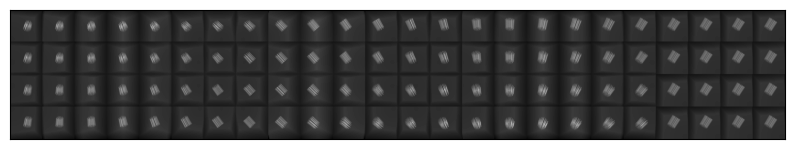

ic| img.shape: torch.Size([1, 1, 256, 256])


torch.Size([1, 1, 256, 256])

In [38]:
#BigImage=torch.zeros(4,256,24,256)
ic(img.shape)
BigImage=img.tile(4,24).resize(4,256,24,256)
ic(BigImage.shape)

for iRow in range(0,4):
  for iCol in range(0,20):
    imod=iRow*20+iCol

    drr = DRR(
        volume,  # The CT volume as a numpy array
        spacing,  # Voxel dimensions of the CT
        sdr=float(vsdr[imod]),  # Source-to-detector radius (half of the source-to-detector distance)
        height=256,  # Height of the DRR (if width is not seperately provided, the generated image is square)
        delx=2.0,  # Pixel spacing (in mm)
          ).to(device)

    # Set the camera pose with rotations (yaw, pitch, roll) and translations (x, y, z)
    rotations = torch.tensor([[float(alpha[imod]), float(beta[imod]), torch.pi / 2]], device=device)
    translations = torch.tensor([[bx, by, bz]], device=device)
    img = drr(rotations, translations, parameterization="euler_angles", convention="ZYX")
    #imgMax=img.max()
    #img[0,0,3:253,3] = imgMax
    #img[0,0,3:253,253] = imgMax
    #img[0,0,3,3:253] = imgMax
    #img[0,0,253,3:253] = imgMax
    BigImage[iRow,:,iCol,:]=img[0,0,:,:]

ic(BigImage.shape)
BigImage=BigImage.reshape(1,1,1024,6144)
ic(BigImage.shape)
plot_drr(BigImage, ticks=False)
plt.show()

ic(img.shape)



# 96 Projections Sparse Angle Case

We also need to create metadata that accompanies this image. In this case, we’ll assume the voxel sizes are 0.7mm. For our projection space, we’ll assume 80 projections are taken at angular spacing of 360/96 degrees. We’ll assume an acquisition radius of 50 cm

In [39]:
angleStep= 360./96.
angles = np.arange(0,360.,angleStep)
ic(angles.shape)
radii = 50 * np.ones(len(angles))
ic(radii.shape)
ic(object_truth[0].shape)
object_meta = SPECTObjectMeta(dr=(spacing[0],spacing[1],spacing[2]), shape=object_truth[0].shape)
ic(object_truth[0,0].shape)
proj_meta = SPECTProjMeta(projection_shape=object_truth[0,0].shape, angles=angles, radii=radii)

ic| angles.shape: (96,)
ic| radii.shape: (96,)
ic| object_truth[0].shape: torch.Size([256, 256, 256])
ic| object_truth[0,0].shape: torch.Size([256, 256])


##Modeling the Imaging System

We’ll model two different imaging systems here: an idealized imaging system, and a true SPECT imaging system. We’ll show that filtered back projection reconstruction only performs well for the idealized system and not for the true SPECT system. The two systems are

An idealized imaging system characterized by the radon transform. In this case
 is simply a projection operator.

Representative of a true SPECT imaging system, with attenuation/PSF modeling. In this case,
 is more complicated.

We’ll neglect scatter for now (equivalent to assuming perfect scatter correction). We’ll show that while filtered back projection does a good job at reconstructing (1), its unable to account for attenuation/PSF modeling in (2)

Case 1:
Our idealized imaging system is simply a SPECT imaging system without attenuation/PSF effects

In [40]:
system_matrix_radon = SPECTSystemMatrix(
    obj2obj_transforms=[],
    proj2proj_transforms=[],
    object_meta=object_meta,
    proj_meta=proj_meta)

Obtaining Imaging Data
We can now use the forward method of system_matrix to model
 (convert the object
 into an image
) for the case of the radon transform

## Obtaining Imaging Data

We can now use the forward method of system_matrix to model
 (convert the object
 into an image
) for the case of (i) the radon transform and (ii) the SPECT system

In [41]:
proj_radon = system_matrix_radon.forward(object_truth)
ic(proj_radon.shape)
#proj_SPECT = system_matrix_SPECT.forward(object_truthFull)

ic| proj_radon.shape: torch.Size([1, 96, 256, 256])


torch.Size([1, 96, 256, 256])

We can look at a projection at 15 degrees increments for example:

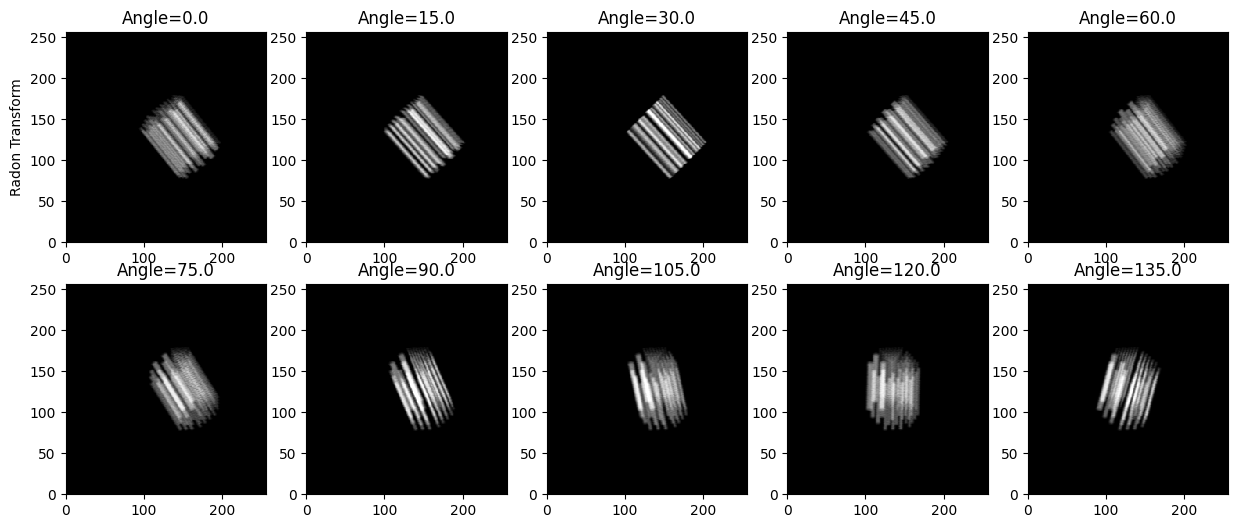

In [42]:
fig, axes = plt.subplots(2,5,figsize=(15,6))
for i, proj_idx in enumerate([0,4,8,12,16]):
    axes[0,i].pcolormesh(proj_radon.cpu()[0][proj_idx].T, cmap='Greys_r', vmax=25)
    axes[0,i].set_title(f'Angle={proj_meta.angles[proj_idx]}')
axes[0,0].set_ylabel('Radon Transform')
for i, proj_idx in enumerate([20,24,28,32,36]):
    axes[1,i].pcolormesh(proj_radon.cpu()[0][proj_idx].T, cmap='Greys_r', vmax=25)
    axes[1,i].set_title(f'Angle={proj_meta.angles[proj_idx]}')
plt.show()

Note that the SPECT system yields an image with less counts (due to attenuation) and is blurrier (due to PSF modeling)

Reconstruction
Filtered back projection is implemented through the FilteredBackProjection class

In [43]:
def filtered_back_projection(proj):
    fbp = FilteredBackProjection(proj, angles)
    object_prediction = fbp()
    return object_prediction

Now we can try reconstructing both the radon transform system and the idealized SPECT system

In [44]:
object_radon_fbp_prediction = filtered_back_projection(proj_radon)
ic(object_radon_fbp_prediction.shape)
#object_SPECT_fbp_prediction = filtered_back_projection(proj_SPECT)

ic| object_radon_fbp_prediction.shape: torch.Size([1, 256, 256, 256])


torch.Size([1, 256, 256, 256])

And we can plot the central axial slice of each reconstruction

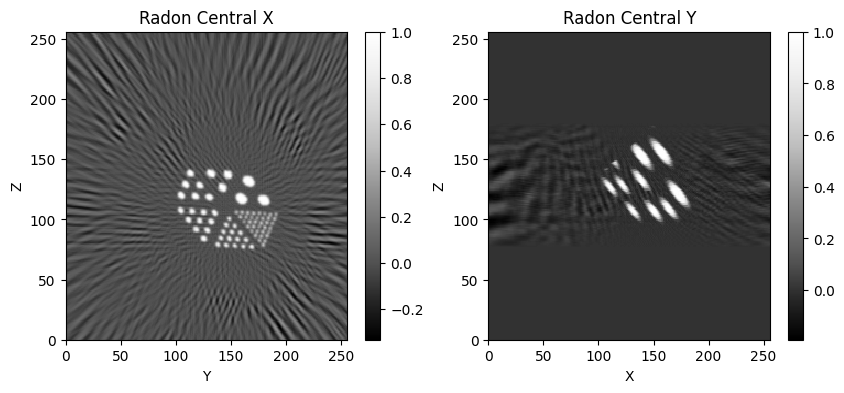

In [45]:
central_Xslice_radon = np.squeeze(object_radon_fbp_prediction.cpu()[0][:,:,128])
central_Yslice_radon = np.squeeze(object_radon_fbp_prediction.cpu()[0][:,128,:])
central_Zslice_radon = np.squeeze(object_radon_fbp_prediction.cpu()[0][128,:,:])
#central_slice_SPECT = np.squeeze(object_SPECT_fbp_prediction.cpu()[0][128,:,:])

plt.subplots(1,2,figsize=(10,4))
plt.subplot(121)
plt.pcolormesh(central_Xslice_radon.T, cmap='Greys_r', vmax=1)
plt.xlabel('Y')
plt.ylabel('Z')
plt.title('Radon Central X')
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(central_Yslice_radon.T, cmap='Greys_r', vmax=1)
plt.xlabel('X')
plt.ylabel('Z')
plt.title('Radon Central Y')
plt.colorbar()
plt.show()

Look at image objects

In [46]:
ic(object_truth.shape)
ic(object_radon_fbp_prediction.shape)

ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| object_radon_fbp_prediction.shape: torch.Size([1, 256, 256, 256])


torch.Size([1, 256, 256, 256])

Look at sparse angle projection objects

In [47]:
proj96_radon=proj_radon
#proj96_SPECT=proj_SPECT

ic(proj96_radon.shape)
#ic(proj96_SPECT.shape)

ic| proj96_radon.shape: torch.Size([1, 96, 256, 256])


torch.Size([1, 96, 256, 256])

Match size and shape of BigImage

plot_drr(proj96_radon[, ticks=False)

ic| proj96_radon.shape: torch.Size([1, 96, 256, 256])
ic| FullRadonImage.shape: (96, 256, 256)
ic| CropRadonImage.shape: (96, 256, 256)
ic| ZoomRadonImage.shape: (96, 256, 256)
ic| ZoomRadonImage.shape: (24, 4, 256, 256)
ic| ReshapeRadonImage.shape: (4, 24, 256, 256)
ic| PermuteRadonImage.shape: (4, 256, 24, 256)


[<Axes: >]

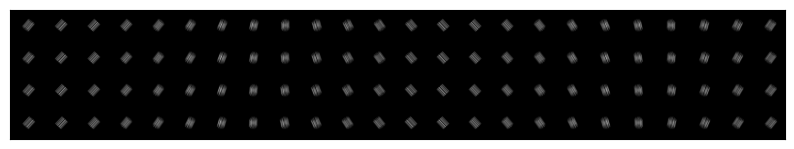

In [48]:
from scipy.ndimage import zoom

ic(proj96_radon.shape)
FullRadonImage=np.squeeze(proj96_radon.cpu().numpy())
ic(FullRadonImage.shape)
CropRadonImage=FullRadonImage[:,:,:]
ic(CropRadonImage.shape)
ZoomRadonImage=zoom(CropRadonImage, (1, 1, 1))
ic(ZoomRadonImage.shape)
ZoomRadonImage=ZoomRadonImage.reshape([24,4,256,256])
ic(ZoomRadonImage.shape)
ReorderRadonImage=np.zeros([96,256,256])
for iRow in range(0,4):
  for iColumn in range(0,24):
    iIndex=iColumn+(iRow*24)
    ReorderRadonImage[iIndex,:,:]=ZoomRadonImage[iColumn,iRow,:,:]

ReshapeRadonImage=ReorderRadonImage.reshape([4,24,256,256])
ic(ReshapeRadonImage.shape)
PermuteRadonImage=ReshapeRadonImage.transpose([0,3,1,2])
ic(PermuteRadonImage.shape)
BigRadonImage=torch.from_numpy(PermuteRadonImage.reshape(1,1,1024,6144))

plot_drr(BigRadonImage, ticks=False)

Compare BigImage

ic| BigImage.shape: torch.Size([1, 1, 1024, 6144])
ic| BigImage.shape: torch.Size([1, 1, 1024, 6144])


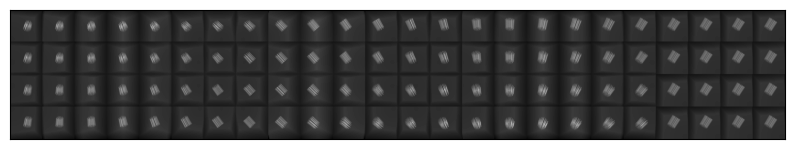

ic| img.shape: torch.Size([1, 1, 256, 256])


torch.Size([1, 1, 256, 256])

In [49]:
#BigImage.shape: torch.Size([4, 256, 24, 256])
ic(BigImage.shape)
BigImage=BigImage.reshape(1,1,1024,6144)
ic(BigImage.shape)
plot_drr(BigImage, ticks=False)
plt.show()

ic(img.shape)

# 720 Projections Full Angle Case

We also need to create metadata that accompanies this image. In this case, we’ll assume the voxel sizes are 0.4 cm. For our projection space, we’ll assume 80 projections are taken at angular spacing of 7.5 degrees. We’ll assume an acquisition radius of 50 cm

In [50]:
angles = np.arange(0,360.,0.5)
ic(angles.shape)
radii = 50 * np.ones(len(angles))
#ic(radii)
object_meta = SPECTObjectMeta(dr=(0.4,0.4,0.4), shape=object_truth[0].shape)
proj_meta = SPECTProjMeta(projection_shape=object_truth[0,0].shape, angles=angles, radii=radii)

ic| angles.shape: (720,)


##Modeling the Imaging System

We’ll model two different imaging systems here: an idealized imaging system, and a true SPECT imaging system. We’ll show that filtered back projection reconstruction only performs well for the idealized system and not for the true SPECT system. The two systems are

An idealized imaging system characterized by the radon transform. In this case
 is simply a projection operator.

Representative of a true SPECT imaging system, with attenuation/PSF modeling. In this case,
 is more complicated.

We’ll neglect scatter for now (equivalent to assuming perfect scatter correction). We’ll show that while filtered back projection does a good job at reconstructing (1), its unable to account for attenuation/PSF modeling in (2)

Case 1:
Our idealized imaging system is simply a SPECT imaging system without attenuation/PSF effects

In [51]:
system_matrix_radon = SPECTSystemMatrix(
    obj2obj_transforms=[],
    proj2proj_transforms=[],
    object_meta=object_meta,
    proj_meta=proj_meta)

Obtaining Imaging Data
We can now use the forward method of system_matrix to model
 (convert the object
 into an image
) for the case of the radon transform

## Obtaining Imaging Data

We can now use the forward method of system_matrix to model
 (convert the object
 into an image
) for the case of (i) the radon transform and (ii) the SPECT system

In [52]:
proj_radon = system_matrix_radon.forward(object_truth)
#proj_SPECT = system_matrix_SPECT.forward(object_truth)

Note that the SPECT system yields an image with less counts (due to attenuation) and is blurrier (due to PSF modeling)

Reconstruction
Filtered back projection is implemented through the FilteredBackProjection class

In [53]:
def filtered_back_projection(proj):
    fbp = FilteredBackProjection(proj, angles)
    object_prediction = fbp()
    return object_prediction

Now we can try reconstructing both the radon transform system and the idealized SPECT system

In [54]:
object_radon_fbp_prediction = filtered_back_projection(proj_radon)
#object_SPECT_fbp_prediction = filtered_back_projection(proj_SPECT)

And we can plot the central axial slice of each reconstruction

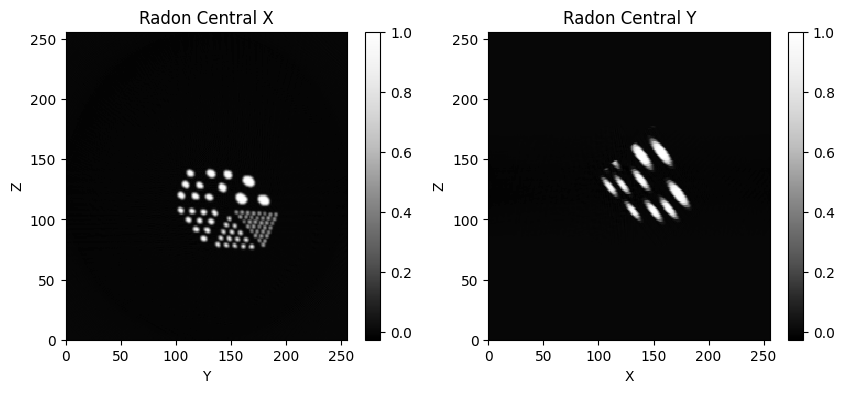

In [55]:
central_Xslice_radon = np.squeeze(object_radon_fbp_prediction.cpu()[0][:,:,128])
central_Yslice_radon = np.squeeze(object_radon_fbp_prediction.cpu()[0][:,128,:])
central_Zslice_radon = np.squeeze(object_radon_fbp_prediction.cpu()[0][128,:,:])
#central_slice_SPECT = np.squeeze(object_SPECT_fbp_prediction.cpu()[0][128,:,:])

plt.subplots(1,2,figsize=(10,4))
plt.subplot(121)
plt.pcolormesh(central_Xslice_radon.T, cmap='Greys_r', vmax=1)
plt.xlabel('Y')
plt.ylabel('Z')
plt.title('Radon Central X')
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(central_Yslice_radon.T, cmap='Greys_r', vmax=1)
plt.xlabel('X')
plt.ylabel('Z')
plt.title('Radon Central Y')
plt.colorbar()
plt.show()

Look at image objects

In [56]:
ic(object_truth.shape)
ic(object_radon_fbp_prediction.shape)

ic| object_truth.shape: torch.Size([1, 256, 256, 256])
ic| object_radon_fbp_prediction.shape: torch.Size([1, 256, 256, 256])


torch.Size([1, 256, 256, 256])

Look at projection objects

In [57]:
ic(proj_radon.shape)
#ic(proj_SPECT.shape)

ic| proj_radon.shape: torch.Size([1, 720, 256, 256])


torch.Size([1, 720, 256, 256])